In [ ]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# For reproducibility in Colab runs
np.set_printoptions(precision=4, suppress=True)

# ==============================
# Data generation utilities
# ==============================

def generate_outlier_illcond_data(
    m_total: int,
    m_outlier: int,
    d: int,
    n_per_group: int,
    noise_std: float,
    cond_normal: float,
    cond_outlier: float,
    spread: float,
    seed: int,
):
    """
    Construct heterogeneous groups:

      - m_normal "normal" groups with moderate eigenvalues.
      - m_outlier "outlier" groups with very large eigenvalues
        in near-orthogonal directions.

    This creates a stacked design matrix with large condition number,
    while most groups individually remain benign.
    """
    rng = np.random.default_rng(seed)
    m_normal = m_total - m_outlier

    # Global orthonormal basis
    U, _ = np.linalg.qr(rng.standard_normal((d, d)))
    k_out = min(m_outlier, d)
    common_dims = max(d - k_out, 1)

    A_groups = []
    b_groups = []

    # Normal groups
    for _ in range(m_normal):
        lambdas = np.ones(d)
        # Moderate spread on a common subspace
        logs = rng.uniform(0.0, math.log10(cond_normal), size=common_dims)
        lambdas[:common_dims] = 10.0 ** logs

        Sigma = U @ np.diag(lambdas) @ U.T
        L = np.linalg.cholesky(Sigma)

        Z = rng.standard_normal((n_per_group, d))
        A_i = (Z @ L.T) / math.sqrt(d)

        x_i_star = spread * rng.standard_normal(d)
        noise = noise_std * rng.standard_normal(n_per_group)
        b_i = A_i @ x_i_star + noise

        A_groups.append(A_i)
        b_groups.append(b_i)

    # Outlier groups: huge eigenvalue in distinct directions
    for j in range(m_outlier):
        lambdas = np.ones(d)
        idx = d - 1 - j
        lambdas[idx] = cond_outlier

        logs = rng.uniform(0.0, 1.0, size=d)
        for t in range(d):
            if t != idx and lambdas[t] == 1.0:
                lambdas[t] = 10.0 ** logs[t]

        Sigma = U @ np.diag(lambdas) @ U.T
        L = np.linalg.cholesky(Sigma)

        Z = rng.standard_normal((n_per_group, d))
        A_i = (Z @ L.T) / math.sqrt(d)

        x_i_star = spread * rng.standard_normal(d)
        noise = noise_std * rng.standard_normal(n_per_group)
        b_i = A_i @ x_i_star + noise

        A_groups.append(A_i)
        b_groups.append(b_i)

    return A_groups, b_groups


# ==============================
# Loss utilities
# ==============================

def group_losses(A_groups, b_groups, x):
    # Mean squared error per group
    return np.array([
        ((A_i @ x - b_i) @ (A_i @ x - b_i)) / len(b_i)
        for A_i, b_i in zip(A_groups, b_groups)
    ])

def max_group_loss(A_groups, b_groups, x):
    return float(group_losses(A_groups, b_groups, x).max())

def solve_system_design(A, b):
    # ERM via pseudoinverse
    return np.linalg.pinv(A) @ b


# ==============================
# Experiment configuration
# ==============================

# Heterogeneity controls
m_total = 20         # total groups
m_outlier = 3        # number of extreme groups
d = 100              # dimension
n_per_group = 200    # samples per group
noise_std = 0.05
cond_normal = 10.0   # typical group condition number scale
cond_outlier = 1e8   # outlier group condition number scale
spread = 5.0         # spread of group-specific optima
seed = 0

# Generate instance
A_groups, b_groups = generate_outlier_illcond_data(
    m_total=m_total,
    m_outlier=m_outlier,
    d=d,
    n_per_group=n_per_group,
    noise_std=noise_std,
    cond_normal=cond_normal,
    cond_outlier=cond_outlier,
    spread=spread,
    seed=seed,
)

A_all = np.vstack(A_groups)
b_all = np.concatenate(b_groups)

# ERM solution (used as a reference baseline)
x_erm = solve_system_design(A_all, b_all)
F_erm = max_group_loss(A_groups, b_groups, x_erm)

# Shared warm starts
x_zero = np.zeros(d)
rng_init = np.random.default_rng(1)
x_rand = rng_init.standard_normal(d)  # single fixed random init used across blocks

print("Constructed instance:")
print(f"  m_total      = {m_total}")
print(f"  m_outlier    = {m_outlier}")
print(f"  d            = {d}")
print(f"  n_per_group  = {n_per_group}")
print(f"  cond_normal  = {cond_normal}")
print(f"  cond_outlier = {cond_outlier}")
print()
print(f"ERM warm start max-loss: {F_erm:.6e}")

# Default warm-start policy; each block can override but must call get_init
DEFAULT_WARM_START = "rand"   # options: "erm", "zero", "rand"

def get_init(warm_start: str):
    if warm_start == "erm":
        return x_erm.copy()
    if warm_start == "zero":
        return x_zero.copy()
    if warm_start == "rand":
        return x_rand.copy()
    raise ValueError("Unknown warm start type")

# Placeholders to collect curves from each block
results_curves = {}
results_final = {"ERM": F_erm}

Constructed instance:
  m_total      = 20
  m_outlier    = 3
  d            = 100
  n_per_group  = 200
  cond_normal  = 10.0
  cond_outlier = 100000000.0

ERM warm start max-loss: 1.277979e+02


In [ ]:
# ============================================================
# Block 2: Subgradient Max-Loss (fixed + diminishing, tunable)
# ============================================================

import numpy as np
import math

def subgradient_max(A_groups, b_groups, x):
    """Subgradient of max_i group_loss_i(x)."""
    ell = group_losses(A_groups, b_groups, x)
    i_star = int(np.argmax(ell))
    A_i, b_i = A_groups[i_star], b_groups[i_star]
    r_i = A_i @ x - b_i
    g_i = (2.0 / len(b_i)) * (A_i.T @ r_i)
    return g_i


def run_subgradient_max_fixed(
    A_groups,
    b_groups,
    x0,
    step,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Fixed-step subgradient on true max-loss.

    Returns None on failure (nan/inf/explosion).

    If record_curve=False:
        - tracks only scalar 'best' and final x (low memory).
    If record_curve=True:
        - returns (iters, best_values) logging EVERY iteration t=0..T
          where 'best_values[t_index]' = best loss up to that iteration.
    """
    x = x0.copy()
    F_init = max_group_loss(A_groups, b_groups, x)
    best = F_init
    explode_threshold = 1e6 * max(F_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        g = subgradient_max(A_groups, b_groups, x)
        if not np.all(np.isfinite(g)):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: grad non-finite.")
            return None

        x = x - step * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: x non-finite.")
            return None

        F = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: F non-finite.")
            return None
        if F > explode_threshold:
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: F exploded to {F:.3e}.")
            return None

        if F < best:
            best = F

        if record_curve:
            iters.append(t)
            best_vals.append(best)
            if verbose:
                print(
                    f"[Subgrad fixed] step={step:.2e}, t={t}, "
                    f"F={F:.6e}, best={best:.6e}"
                )

    return {
        "mode": "fixed",
        "step": step,
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best": best,
    }


def run_subgradient_max_diminishing(
    A_groups,
    b_groups,
    x0,
    base_step,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Diminishing-step subgradient:
        eta_t = base_step / sqrt(t).

    Same interface and failure logic as fixed-step version.
    """
    x = x0.copy()
    F_init = max_group_loss(A_groups, b_groups, x)
    best = F_init
    explode_threshold = 1e6 * max(F_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        eta = base_step / math.sqrt(t)
        g = subgradient_max(A_groups, b_groups, x)
        if not np.all(np.isfinite(g)):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: grad non-finite.")
            return None

        x = x - eta * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: x non-finite.")
            return None

        F = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: F non-finite.")
            return None
        if F > explode_threshold:
            if verbose:
                print(
                    f"[Subgrad dim] base={base_step:.2e}, t={t}: "
                    f"F exploded to {F:.3e}."
                )
            return None

        if F < best:
            best = F

        if record_curve:
            iters.append(t)
            best_vals.append(best)
            if verbose:
                print(
                    f"[Subgrad dim] base={base_step:.2e}, t={t}, "
                    f"F={F:.6e}, best={best:.6e}"
                )

    return {
        "mode": "diminishing",
        "base_step": base_step,
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best": best,
    }


def tune_subgradient_max(
    A_groups,
    b_groups,
    x0,
    T_fixed=100,
    T_dim=100,
    verbose=False,
):
    """
    Tune both:
      - fixed step size,
      - diminishing base step size.

    Uses best loss along each 0..T trajectory as the score.
    During tuning:
      - record_curve=False (low memory),
      - prints one summary line per candidate.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[Subgrad tune] init F = {F_init:.6e}")

    # Grids (you can widen if needed)
    step_grid = np.logspace(-8, -5, 7)      # fixed steps
    base_step_grid = np.logspace(-7, -4, 7) # diminishing base steps

    best_overall = None
    best_val = float("inf")

    # Fixed-step tuning
    for step in step_grid:
        res = run_subgradient_max_fixed(
            A_groups,
            b_groups,
            x0,
            step=step,
            T=T_fixed,
            verbose=verbose,
            record_curve=False,
        )
        if res is None:
            print(f"[Subgrad tune] fixed step={step:.2e} -> FAILED")
            continue

        val = res["best"]
        print(f"[Subgrad tune] fixed step={step:.2e} -> best={val:.6e}")

        if val + 1e-9 < best_val:
            best_val = val
            best_overall = {
                "mode": "fixed",
                "step": float(step),
            }

    # Diminishing-step tuning
    for base in base_step_grid:
        res = run_subgradient_max_diminishing(
            A_groups,
            b_groups,
            x0,
            base_step=base,
            T=T_dim,
            verbose=verbose,
            record_curve=False,
        )
        if res is None:
            print(f"[Subgrad tune] dim base={base:.2e} -> FAILED")
            continue

        val = res["best"]
        print(f"[Subgrad tune] dim base={base:.2e} -> best={val:.6e}")

        if val + 1e-9 < best_val:
            best_val = val
            best_overall = {
                "mode": "diminishing",
                "base_step": float(base),
            }

    return best_overall, best_val


# ===== Run subgradient tuning and final curve =====

warm_start_subgrad = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_subgrad = get_init(warm_start_subgrad)

print(f"\n[Subgrad] Using warm start = {warm_start_subgrad}")
print("init max-loss            =", max_group_loss(A_groups, b_groups, x0_subgrad))
print("||subgrad(max) at init|| =", np.linalg.norm(subgradient_max(A_groups, b_groups, x0_subgrad)))

subgrad_cfg, subgrad_best = tune_subgradient_max(
    A_groups,
    b_groups,
    x0_subgrad,
    T_fixed=100,
    T_dim=100,
    verbose=False,  # set True for inner-iteration debug
)

if subgrad_cfg is not None:
    # Final run for plotting: T=100, log EVERY iteration
    if subgrad_cfg["mode"] == "fixed":
        final_res = run_subgradient_max_fixed(
            A_groups,
            b_groups,
            x0_subgrad,
            step=subgrad_cfg["step"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "Subgradient Max (fixed)"
    else:
        final_res = run_subgradient_max_diminishing(
            A_groups,
            b_groups,
            x0_subgrad,
            base_step=subgrad_cfg["base_step"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "Subgradient Max (dim)"

    if final_res is not None and final_res["iters"] is not None:
        x_final = final_res["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)
        results_curves[label] = {
            "iters": final_res["iters"],          # length 101: 0..100
            "best_values": final_res["best_values"],
        }
        results_final[label] = F_final
        print(f"[Subgrad] mode={subgrad_cfg['mode']}, cfg={subgrad_cfg}, final max-loss={F_final:.6e}")
    else:
        print("[Subgrad] Final run failed; no curve recorded.")
else:
    print("[Subgrad] No stable configuration found.")


[Subgrad] Using warm start = rand
init max-loss            = 58700421.229777366
||subgrad(max) at init|| = 15943387.917721016
[Subgrad tune] init F = 5.870042e+07
[Subgrad tune] fixed step=1.00e-08 -> best=1.141565e+06
[Subgrad tune] fixed step=3.16e-08 -> best=4.242077e+04
[Subgrad tune] fixed step=1.00e-07 -> best=1.504109e+02
[Subgrad tune] fixed step=3.16e-07 -> best=1.504102e+02
[Subgrad tune] fixed step=1.00e-06 -> FAILED
[Subgrad tune] fixed step=3.16e-06 -> FAILED
[Subgrad tune] fixed step=1.00e-05 -> FAILED
[Subgrad tune] dim base=1.00e-07 -> best=2.682732e+05
[Subgrad tune] dim base=3.16e-07 -> best=5.302580e+02
[Subgrad tune] dim base=1.00e-06 -> best=1.504136e+02
[Subgrad tune] dim base=3.16e-06 -> FAILED
[Subgrad tune] dim base=1.00e-05 -> FAILED
[Subgrad tune] dim base=3.16e-05 -> FAILED
[Subgrad tune] dim base=1.00e-04 -> FAILED
[Subgrad] mode=fixed, cfg={'mode': 'fixed', 'step': 3.162277660168379e-07}, final max-loss=1.504102e+02


In [ ]:
# ============================================================
# Block 3: Smoothed-Max Gradient Descent (tuned smoothing)
# ============================================================

import numpy as np
import math

# ---------- Core smoothing primitives ----------

def smooth_max_value_and_grad(A_groups, b_groups, x, beta, delta):
    """
    Compute smoothed max value F_smooth(x) and its gradient.

    Uses:
      ell_i(x) = group loss >= 0
      If delta > 0:
        s_i   = sqrt(delta^2 + ell_i^2)
        psi_i = s_i - delta
        F     = beta * log sum_i exp(psi_i / beta)
        gradF = sum_i w_i * (ell_i / s_i) * grad ell_i
      If delta == 0:
        psi_i = ell_i
        F     = beta * log sum_i exp(ell_i / beta)
        gradF = sum_i w_i * grad ell_i
      where w_i is the softmax over psi_i / beta.

    Returns:
      F_smooth (float), grad (ndarray)
    """
    ell = group_losses(A_groups, b_groups, x)  # shape (m,)
    if not np.all(np.isfinite(ell)):
        return None, None

    if beta <= 0:
        return None, None

    # Compute psi_i
    if delta > 0:
        s = np.sqrt(delta * delta + ell * ell)
        psi = s - delta
    else:
        psi = ell.copy()

    z = psi / beta
    z_max = np.max(z)
    exp_z = np.exp(z - z_max)
    Z = exp_z.sum()
    if not np.isfinite(Z) or Z <= 0:
        return None, None

    w = exp_z / Z
    F_smooth = float(beta * (z_max + math.log(Z)))
    if not np.isfinite(F_smooth):
        return None, None

    # Gradients of ell_i
    grads = []
    for A_i, b_i in zip(A_groups, b_groups):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]
        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        grads.append(g_i)
    grads = np.array(grads)  # (m, d)

    # Combine
    if delta > 0:
        s = np.sqrt(delta * delta + ell * ell)
        coeff = (ell / np.maximum(s, 1e-16)) * w
    else:
        coeff = w

    grad = (coeff[:, None] * grads).sum(axis=0)
    if not np.all(np.isfinite(grad)):
        return None, None

    return F_smooth, grad


# ---------- Single run ----------

def run_smooth_gd(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    step,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Gradient descent on F_smooth with fixed (beta, delta, step).

    Failure conditions:
      - non-finite F_smooth or grad,
      - non-finite x,
      - explosion of true max-loss by large factor.

    If record_curve=False:
      - only tracks scalar best_true and final x.
    If record_curve=True:
      - logs EVERY iteration t=0..T:
        iters[t_index] = t
        best_values[t_index] = best true max-loss up to iteration t.
    """
    x = x0.copy()
    F_true_init = max_group_loss(A_groups, b_groups, x)
    best_true = F_true_init
    explode_threshold = 1e6 * max(F_true_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        F_sm, g = smooth_max_value_and_grad(A_groups, b_groups, x, beta, delta)
        if F_sm is None or g is None:
            if verbose:
                print(
                    f"[F_smooth GD] beta={beta:.2e},delta={delta:.2e},"
                    f"step={step:.2e}, t={t}: bad F/grad."
                )
            return None

        x = x - step * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(
                    f"[F_smooth GD] beta={beta:.2e},delta={delta:.2e},"
                    f"step={step:.2e}, t={t}: x non-finite."
                )
            return None

        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(
                    f"[F_smooth GD] beta={beta:.2e},delta={delta:.2e},"
                    f"step={step:.2e}, t={t}: F_true non-finite."
                )
            return None
        if F_true > explode_threshold:
            if verbose:
                print(
                    f"[F_smooth GD] beta={beta:.2e},delta={delta:.2e},"
                    f"step={step:.2e}, t={t}: F_true exploded {F_true:.3e}."
                )
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(t)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[F_smooth GD] beta={beta:.2e},delta={delta:.2e},"
                    f"step={step:.2e}, t={t}, "
                    f"F_true={F_true:.6e}, best={best_true:.6e}"
                )

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
    }


# ---------- Tuning ----------

def tune_smooth_gd(
    A_groups,
    b_groups,
    x0,
    T=100,
    verbose=False,
):
    """
    Brute-force tuning over beta, delta (including 0), and step.

    Uses best true max-loss along each 0..T trajectory as the score.
    During tuning:
      - record_curve=False (low memory),
      - prints one summary line per candidate.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[F_smooth GD tune] init true max-loss = {F_init:.6e}")

    # Instance-adaptive grids
    beta_rel = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
    delta_rel = [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
    step_grid = np.logspace(-6, -2, 9)  # 1e-6 ... 1e-2

    beta_grid = [br * F_init for br in beta_rel]
    delta_grid = [dr * F_init for dr in delta_rel]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        if beta <= 0:
            continue
        for delta in delta_grid:
            for step in step_grid:
                res = run_smooth_gd(
                    A_groups,
                    b_groups,
                    x0,
                    beta=beta,
                    delta=delta,
                    step=step,
                    T=T,
                    verbose=verbose,
                    record_curve=False,
                )
                if res is None:
                    print(
                        f"[F_smooth GD tune] beta={beta:.2e},"
                        f"delta={delta:.2e},step={step:.2e} -> FAILED"
                    )
                    continue

                val = res["best_true"]
                print(
                    f"[F_smooth GD tune] beta={beta:.2e},"
                    f"delta={delta:.2e},step={step:.2e} -> best={val:.6e}"
                )

                if np.isfinite(val) and val + 1e-9 < best_val:
                    best_val = val
                    best_cfg = {
                        "beta": float(beta),
                        "delta": float(delta),
                        "step": float(step),
                    }

    return best_cfg, best_val


# ---------- Run block and store best curve ----------

warm_start_smooth = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_smooth = get_init(warm_start_smooth)

print(f"\n[F_smooth GD] Using warm start = {warm_start_smooth}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_smooth))

smooth_cfg, smooth_best = tune_smooth_gd(
    A_groups,
    b_groups,
    x0_smooth,
    T=100,
    verbose=False,  # set True for detailed inner logs
)

if smooth_cfg is not None:
    print(
        "[F_smooth GD] Selected cfg:",
        smooth_cfg,
        "with best tuned value:",
        smooth_best,
    )

    final_res = run_smooth_gd(
        A_groups,
        b_groups,
        x0_smooth,
        beta=smooth_cfg["beta"],
        delta=smooth_cfg["delta"],
        step=smooth_cfg["step"],
        T=100,
        verbose=False,
        record_curve=True,  # log every iter 0..100
    )

    if final_res is not None and final_res["iters"] is not None:
        x_final = final_res["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)
        label = "F_smooth GD"
        results_curves[label] = {
            "iters": final_res["iters"],          # length 101: 0..100
            "best_values": final_res["best_values"],
        }
        results_final[label] = F_final
        print(f"[F_smooth GD] final true max-loss = {F_final:.6e}")
    else:
        print("[F_smooth GD] Final run failed; no curve recorded.")
else:
    print("[F_smooth GD] No stable configuration found.")


[F_smooth GD] Using warm start = rand
init true max-loss       = 58700421.229777366
[F_smooth GD tune] init true max-loss = 5.870042e+07
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-06 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=3.16e-06 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-05 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=3.16e-05 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-04 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=3.16e-04 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-03 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=3.16e-03 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-02 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=5.87e+02,step=1.00e-06 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=5.87e+02,step=3.16e-06 -> FAILED
[F_smooth GD tune] beta=5.87e+04,delta=5.87e+02,step=1.00e-05 -> FAILE

In [ ]:
# ============================================================
# Block: Interior-Point Method (IPM) for max-group loss
# Uses same get_init(...) convention as other methods
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Barrier objective and derivatives
# ------------------------------------------------------------

def ipm_barrier_objective(A_groups, b_groups, x, t, mu):
    """
    phi(x, t; mu) = t - mu * sum_i log(t - ell_i(x)),
    where ell_i(x) is the group loss for group i.

    Returns +inf if outside domain or numerically invalid.
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or not np.isfinite(t):
        return np.inf

    slack = t - ell
    if np.any(slack <= 0):
        return np.inf

    val = t - mu * np.sum(np.log(slack))
    return float(val) if np.isfinite(val) else np.inf


def ipm_barrier_grad_hess(A_groups, b_groups, x, t, mu):
    """
    Gradient and Hessian of phi(x,t;mu) with respect to [x; t].

    For each group i:
      ell_i(x) = (1/n_i) ||A_i x - b_i||^2
      g_i(x)   = grad_x ell_i(x) = (2/n_i) A_i^T (A_i x - b_i)
      H_i(x)   = Hess_x ell_i(x) = (2/n_i) A_i^T A_i

    With slack_i = t - ell_i(x):
      grad_x =  mu * sum_i (1/slack_i) * g_i
      grad_t =  1 - mu * sum_i (1/slack_i)

      H_xx = mu * sum_i [ (1/slack_i) H_i + (1/slack_i^2) g_i g_i^T ]
      H_xt = -mu * sum_i (1/slack_i^2) g_i
      H_tt =  mu * sum_i (1/slack_i^2)
    """
    d = A_groups[0].shape[1]
    m = len(A_groups)

    ell = np.empty(m)
    g_arr = np.empty((m, d))
    H_list = []

    for idx, (A_i, b_i) in enumerate(zip(A_groups, b_groups)):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]

        ell_i = (r_i @ r_i) / n_i
        if not np.isfinite(ell_i):
            return None, None

        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None, None

        H_i = (2.0 / n_i) * (A_i.T @ A_i)

        ell[idx] = ell_i
        g_arr[idx, :] = g_i
        H_list.append(H_i)

    if not np.isfinite(t):
        return None, None

    slack = t - ell
    if np.any(slack <= 0):
        return None, None

    inv = 1.0 / slack
    inv2 = inv * inv

    # Gradient
    grad_x = mu * (inv[:, None] * g_arr).sum(axis=0)
    grad_t = 1.0 - mu * inv.sum()

    # Hessian
    H_xx = np.zeros((d, d))
    for i in range(m):
        H_i = H_list[i]
        g_i = g_arr[i]
        H_xx += mu * (inv[i] * H_i + inv2[i] * np.outer(g_i, g_i))

    H_xt = -mu * (inv2[:, None] * g_arr).sum(axis=0)
    H_tt = mu * inv2.sum()

    H = np.zeros((d + 1, d + 1))
    H[:d, :d] = H_xx
    H[:d, d] = H_xt
    H[d, :d] = H_xt
    H[d, d] = H_tt

    grad = np.zeros(d + 1)
    grad[:d] = grad_x
    grad[d] = grad_t

    if not np.all(np.isfinite(grad)) or not np.all(np.isfinite(H)):
        return None, None

    # Light regularization
    H += 1e-10 * np.eye(d + 1)

    return grad, H


# ------------------------------------------------------------
# 2. Single IPM run for a fixed (mu0, tau, inner_iters)
# ------------------------------------------------------------

def run_ipm(
    A_groups,
    b_groups,
    x0,
    mu0=1e-3,
    tau=0.9,
    inner_iters=10,
    max_newton_steps=100,
    backtrack_beta=0.5,
    backtrack_c=1e-4,
    verbose=False,
    record_curve=False,
):
    """
    Log-barrier IPM on:

        minimize_{x,t} t
        s.t. ell_i(x) <= t for all i.

    Uses x0 as given (no internal randomness).

    Initialization:
      x = x0,
      t0 = max_i ell_i(x0) + gamma,
      gamma = max(10, 10 * |max_ell0|).

    If record_curve=True:
      - logs every iteration k=0..max_newton_steps:
        iters[0]     = 0 (initial)
        best_values[0] = F_true_init
        then best-so-far after each Newton step.
    """
    d = A_groups[0].shape[1]

    x = x0.copy()
    ell0 = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell0)):
        if verbose:
            print("[IPM] Non-finite losses at x0.")
        return None

    max_ell0 = float(np.max(ell0))
    gamma = max(10.0, 10.0 * abs(max_ell0))
    t = max_ell0 + gamma

    mu = float(mu0)

    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[IPM] Non-finite initial F_true.")
        return None

    base_scale = max(F_true, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_true

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, max_newton_steps + 1):
        phi_val = ipm_barrier_objective(A_groups, b_groups, x, t, mu)
        if not np.isfinite(phi_val):
            if verbose:
                print(f"[IPM] Non-finite phi at step {k}.")
            return None

        grad, H = ipm_barrier_grad_hess(A_groups, b_groups, x, t, mu)
        if grad is None or H is None:
            if verbose:
                print(f"[IPM] Grad/Hess failure at step {k}.")
            return None

        try:
            delta = np.linalg.solve(H, -grad)
        except np.linalg.LinAlgError:
            if verbose:
                print(f"[IPM] Hessian solve failed at step {k}.")
            return None

        dx = delta[:d]
        dt = delta[d]

        # Backtracking line search that preserves feasibility
        alpha = 1.0
        success = False
        for _ in range(80):
            x_new = x + alpha * dx
            t_new = t + alpha * dt

            ell_new = group_losses(A_groups, b_groups, x_new)
            if np.all(np.isfinite(ell_new)):
                slack_new = t_new - ell_new
                if np.all(slack_new > 1e-10) and np.isfinite(t_new):
                    phi_new = ipm_barrier_objective(
                        A_groups, b_groups, x_new, t_new, mu
                    )
                    if (
                        np.isfinite(phi_new)
                        and phi_new
                        <= phi_val + backtrack_c * alpha * (grad @ delta)
                    ):
                        success = True
                        break
            alpha *= backtrack_beta

        if not success:
            if verbose:
                print(f"[IPM] Line search failed at step {k}.")
            return None

        x, t = x_new, t_new

        # True objective and safety
        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[IPM] Non-finite F_true at step {k}.")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(f"[IPM] Explosion: F_true={F_true:.3e} at step {k}.")
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[IPM] k={k}, mu={mu:.2e}, "
                    f"phi={phi_new:.6e}, F_true={F_true:.6e}, "
                    f"best={best_true:.6e}"
                )
        elif verbose:
            if k % 5 == 0:
                print(
                    f"[IPM] k={k}, mu={mu:.2e}, "
                    f"phi={phi_new:.6e}, F_true={F_true:.6e}, "
                    f"best={best_true:.6e}"
                )

        # Update barrier parameter every inner_iters steps
        if (k % inner_iters) == 0:
            mu *= tau

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "t_final": t,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 3. Hyperparameter tuning (no new randomness)
# ------------------------------------------------------------

def tune_ipm(A_groups, b_groups, x0, max_newton_steps=100, verbose=False):
    """
    Grid search over (mu0, tau, inner_iters).

    Score = best true max-loss along the trajectory (0..max_newton_steps).
    Uses given x0, no internal resampling.
    Prints one summary line per candidate.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[IPM tune] init true max-loss = {F_init:.6e}")

    mu0_list = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    tau_list = [0.99, 0.95, 0.9, 0.7, 0.5]
    inner_list = [3, 5, 10, 20]

    best_cfg = None
    best_val = float("inf")

    for mu0 in mu0_list:
        for tau in tau_list:
            for inner in inner_list:
                res = run_ipm(
                    A_groups,
                    b_groups,
                    x0,
                    mu0=mu0,
                    tau=tau,
                    inner_iters=inner,
                    max_newton_steps=max_newton_steps,
                    verbose=verbose,
                    record_curve=False,
                )
                if res is None:
                    print(
                        f"[IPM tune] mu0={mu0:.1e},tau={tau:.2f},inner={inner} "
                        f"-> FAILED"
                    )
                    continue

                val = res["best_true"]
                print(
                    f"[IPM tune] mu0={mu0:.1e},tau={tau:.2f},inner={inner} "
                    f"-> best={val:.6e}"
                )

                if np.isfinite(val) and val + 1e-9 < best_val:
                    best_val = val
                    best_cfg = {
                        "mu0": float(mu0),
                        "tau": float(tau),
                        "inner_iters": int(inner),
                    }

    return best_cfg, best_val


# ------------------------------------------------------------
# 4. Run IPM with same-style warm start and store curve
# ------------------------------------------------------------

warm_start_ipm = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_ipm = get_init(warm_start_ipm)

print(f"\n[IPM] Using warm start = {warm_start_ipm}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_ipm))

ipm_cfg, ipm_best = tune_ipm(
    A_groups,
    b_groups,
    x0_ipm,
    max_newton_steps=100,
    verbose=False,  # set True to inspect inner steps
)

if ipm_cfg is not None:
    print("[IPM] Selected cfg:", ipm_cfg, "with best tuned value:", ipm_best)

    final_ipm = run_ipm(
        A_groups,
        b_groups,
        x0_ipm,
        mu0=ipm_cfg["mu0"],
        tau=ipm_cfg["tau"],
        inner_iters=ipm_cfg["inner_iters"],
        max_newton_steps=100,
        verbose=False,
        record_curve=True,  # log every step 0..100
    )

    if final_ipm is not None and final_ipm["iters"] is not None:
        x_final = final_ipm["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "IPM"
        results_curves[label] = {
            "iters": final_ipm["iters"],          # length up to 101: 0..100
            "best_values": final_ipm["best_values"],
        }
        results_final[label] = F_final

        print(f"[IPM] final true max-loss = {F_final:.6e}")
    else:
        print("[IPM] Final IPM run failed; no curve recorded.")
else:
    print("[IPM] No stable IPM configuration found.")


[IPM] Using warm start = rand
init true max-loss       = 58700421.229777366
[IPM tune] init true max-loss = 5.870042e+07
[IPM tune] mu0=1.0e-04,tau=0.99,inner=3 -> best=9.875234e+01
[IPM tune] mu0=1.0e-04,tau=0.99,inner=5 -> best=9.875236e+01
[IPM tune] mu0=1.0e-04,tau=0.99,inner=10 -> best=9.875238e+01
[IPM tune] mu0=1.0e-04,tau=0.99,inner=20 -> best=9.875239e+01
[IPM tune] mu0=1.0e-04,tau=0.95,inner=3 -> best=9.875208e+01
[IPM tune] mu0=1.0e-04,tau=0.95,inner=5 -> best=9.875225e+01
[IPM tune] mu0=1.0e-04,tau=0.95,inner=10 -> best=9.875246e+01
[IPM tune] mu0=1.0e-04,tau=0.95,inner=20 -> best=9.875261e+01
[IPM tune] mu0=1.0e-04,tau=0.90,inner=3 -> best=9.875194e+01
[IPM tune] mu0=1.0e-04,tau=0.90,inner=5 -> best=9.875203e+01
[IPM tune] mu0=1.0e-04,tau=0.90,inner=10 -> best=9.875225e+01
[IPM tune] mu0=1.0e-04,tau=0.90,inner=20 -> best=9.875248e+01
[IPM tune] mu0=1.0e-04,tau=0.70,inner=3 -> best=9.875191e+01
[IPM tune] mu0=1.0e-04,tau=0.70,inner=5 -> best=1.004103e+02
[IPM tune] mu0=1.0

In [ ]:
# ============================================================
# Block: Ball-Oracle Naive Geometry (Smoothed Max-Loss)
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Smoothed objective (shared by naive / Lewis versions)
# ------------------------------------------------------------

def fsmooth_value(A_groups, b_groups, x, beta, delta):
    """
    Smoothed approximation of max_i ell_i(x).

    If delta = 0:
        F_smooth(x) = beta * log sum_i exp(ell_i / beta)
    If delta > 0:
        s_i = sqrt(delta^2 + ell_i^2)
        z_i = (s_i - delta) / beta
        F_smooth(x) = beta * log sum_i exp(z_i)
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)):
        return np.inf
    if beta <= 0:
        return np.inf

    if delta == 0.0:
        z = ell / beta
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return np.inf
        z = (s - delta) / beta

    z_max = np.max(z)
    if not np.isfinite(z_max):
        return np.inf

    exp_z = np.exp(z - z_max)
    S = np.sum(exp_z)
    if S <= 0 or not np.isfinite(S):
        return np.inf

    val = beta * (z_max + np.log(S))
    return float(val) if np.isfinite(val) else np.inf


def fsmooth_grad(A_groups, b_groups, x, beta, delta):
    """
    Gradient of F_smooth w.r.t. x.

    If delta = 0:
        grad = sum_i softmax_i(ell/beta) * grad ell_i(x)

    If delta > 0:
        grad = sum_i w_i * (ell_i / s_i) * grad ell_i(x),
        where w_i is softmax over (s_i - delta)/beta and s_i = sqrt(delta^2 + ell_i^2).
    """
    m = len(A_groups)
    d = A_groups[0].shape[1]

    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or beta <= 0:
        return None

    # Gradients of ell_i
    g_arr = np.empty((m, d))
    for idx, (A_i, b_i) in enumerate(zip(A_groups, b_groups)):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]
        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None
        g_arr[idx, :] = g_i

    if delta == 0.0:
        z = ell / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None
        w = exp_z / S
        grad = (w[:, None] * g_arr).sum(axis=0)
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return None
        z = (s - delta) / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None
        w = exp_z / S

        ratio = np.zeros_like(ell)
        mask = s > 0
        ratio[mask] = ell[mask] / s[mask]

        grad = (w[:, None] * ratio[:, None] * g_arr).sum(axis=0)

    if not np.all(np.isfinite(grad)):
        return None
    return grad


# ------------------------------------------------------------
# 2. Naive-geometry ball-oracle style method
# ------------------------------------------------------------

def run_ball_oracle_naive(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    step,
    R0,
    n_outer,
    n_inner,
    shrink=0.99,
    max_iters=100,
    verbose=False,
    record_curve=False,
):
    """
    Naive geometry variant of our smoothed ball-oracle method.

    - Uses Euclidean balls around current center.
    - Outer loop k:
        radius R_k, center = current x.
        run n_inner gradient steps on F_smooth with projection.
        update center <- x, R_k+1 = shrink * R_k.
    - max_iters caps TOTAL gradient steps (for fairness).

    Evaluation uses TRUE max-loss. F_smooth only guides steps.

    If record_curve=True:
      - iters[0] = 0 with best_vals[0] = F_init
      - then logs every gradient step (1..max_iters).
    """
    d = A_groups[0].shape[1]
    x = x0.copy()
    center = x0.copy()
    R = float(R0)

    F_init = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_init):
        if verbose:
            print("[BallOracle naive] Non-finite init loss.")
        return None

    base_scale = max(F_init, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_init
    F_true = F_init

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    it = 0
    # Outer/inner loops with total step budget
    for k in range(1, n_outer + 1):
        for j in range(1, n_inner + 1):
            if it >= max_iters:
                break

            it += 1

            g = fsmooth_grad(A_groups, b_groups, x, beta, delta)
            if g is None:
                if verbose:
                    print(
                        f"[BallOracle naive] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e}: grad non-finite at outer={k}, inner={j}"
                    )
                return None

            x_new = x - step * g
            if not np.all(np.isfinite(x_new)):
                if verbose:
                    print(
                        f"[BallOracle naive] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e}: x non-finite at iter {it}"
                    )
                return None

            # Project onto Euclidean ball around current center
            diff = x_new - center
            norm_diff = np.linalg.norm(diff)
            if norm_diff > R:
                x_new = center + (R / max(norm_diff, 1e-16)) * diff

            x = x_new

            F_true = max_group_loss(A_groups, b_groups, x)
            if not np.isfinite(F_true):
                if verbose:
                    print(
                        f"[BallOracle naive] Non-finite F_true at iter {it}: {F_true}"
                    )
                return None
            if F_true > explode_threshold:
                if verbose:
                    print(
                        f"[BallOracle naive] Explosion at iter {it}: "
                        f"F_true={F_true:.3e}"
                    )
                return None

            if F_true < best_true:
                best_true = F_true

            if record_curve:
                iters.append(it)
                best_vals.append(best_true)
                if verbose:
                    print(
                        f"[BallOracle naive] it={it}, F_true={F_true:.6e}, "
                        f"best={best_true:.6e}, R={R:.3e}"
                    )

        # End of outer loop: update center, shrink radius
        center = x.copy()
        R *= shrink
        if R <= 0 or it >= max_iters:
            break

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 3. Tuning for naive-geometry ball-oracle
# ------------------------------------------------------------

def tune_ball_oracle_naive(
    A_groups,
    b_groups,
    x0,
    max_iters=100,
    verbose=False,
):
    """
    Grid search over (beta, delta, step, R0, n_outer, n_inner, shrink).

    - Uses x0 as given (no randomness).
    - Enforces n_outer * n_inner >= max_iters so each config
      can use the full iteration budget.
    - Score: best TRUE max-loss along trajectory (0..max_iters).
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[BallOracle naive tune] init true max-loss = {F_init:.6e}")

    base = max(F_init, 1.0)

    beta_grid = base * np.logspace(-3, 0, 5)   # [1e-3, ..., 1] * base
    delta_multipliers = [0.0, 1e-2, 1e-1]      # relative to beta
    step_grid = np.logspace(-8, -5, 4)

    xnorm = float(np.linalg.norm(x0))
    base_R = xnorm if xnorm > 0 else 1.0
    R_grid = [0.5 * base_R, 1.0 * base_R, 2.0 * base_R]

    n_outer_list = [5, 10]
    n_inner_list = [5, 10]
    shrink_list = [0.99, 0.95]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        for dm in delta_multipliers:
            delta = dm * beta
            for step in step_grid:
                for R0 in R_grid:
                    for n_outer in n_outer_list:
                        for n_inner in n_inner_list:
                            # Require enough steps to fill budget
                            if n_outer * n_inner < max_iters:
                                continue
                            for shrink in shrink_list:
                                res = run_ball_oracle_naive(
                                    A_groups,
                                    b_groups,
                                    x0,
                                    beta=beta,
                                    delta=delta,
                                    step=step,
                                    R0=R0,
                                    n_outer=n_outer,
                                    n_inner=n_inner,
                                    shrink=shrink,
                                    max_iters=max_iters,
                                    verbose=False,
                                    record_curve=False,
                                )
                                if res is None:
                                    print(
                                        "[BallOracle naive tune] "
                                        f"beta={beta:.2e},delta={delta:.2e},"
                                        f"step={step:.2e},R0={R0:.2e},"
                                        f"outer={n_outer},inner={n_inner},"
                                        f"shrink={shrink:.2f} -> FAILED"
                                    )
                                    continue

                                val = res["best_true"]
                                print(
                                    "[BallOracle naive tune] "
                                    f"beta={beta:.2e},delta={delta:.2e},"
                                    f"step={step:.2e},R0={R0:.2e},"
                                    f"outer={n_outer},inner={n_inner},"
                                    f"shrink={shrink:.2f} "
                                    f"-> best={val:.6e}"
                                )

                                if np.isfinite(val) and val + 1e-9 < best_val:
                                    best_val = val
                                    best_cfg = {
                                        "beta": float(beta),
                                        "delta": float(delta),
                                        "step": float(step),
                                        "R0": float(R0),
                                        "n_outer": int(n_outer),
                                        "n_inner": int(n_inner),
                                        "shrink": float(shrink),
                                    }

    return best_cfg, best_val


# ------------------------------------------------------------
# 4. Run naive-geometry method with shared-style warm start
# ------------------------------------------------------------

warm_start_naive = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_naive = get_init(warm_start_naive)

print(f"\n[BallOracle naive] Using warm start = {warm_start_naive}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_naive))

naive_cfg, naive_best = tune_ball_oracle_naive(
    A_groups,
    b_groups,
    x0_naive,
    max_iters=100,
    verbose=False,
)

if naive_cfg is not None:
    print(
        "[BallOracle naive] Selected cfg:",
        naive_cfg,
        "with best tuned value:",
        naive_best,
    )

    final_naive = run_ball_oracle_naive(
        A_groups,
        b_groups,
        x0_naive,
        beta=naive_cfg["beta"],
        delta=naive_cfg["delta"],
        step=naive_cfg["step"],
        R0=naive_cfg["R0"],
        n_outer=naive_cfg["n_outer"],
        n_inner=naive_cfg["n_inner"],
        shrink=naive_cfg["shrink"],
        max_iters=100,
        verbose=False,
        record_curve=True,  # log every iter 0..100
    )

    if final_naive is not None and final_naive["iters"] is not None:
        x_final = final_naive["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Naive Geometry"
        results_curves[label] = {
            "iters": final_naive["iters"],
            "best_values": final_naive["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle naive] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle naive] Final run failed; no curve recorded.")
else:
    print("[BallOracle naive] No stable configuration found.")


[BallOracle naive] Using warm start = rand
init true max-loss       = 58700421.229777366
[BallOracle naive tune] init true max-loss = 5.870042e+07
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=4.27e+00,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=4.27e+00,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=8.55e+00,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=8.55e+00,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=1.71e+01,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=1.71e+01,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle naive tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-07,R0=4.

In [ ]:
# ============================================================
# Block: Ball-Oracle Lewis Geometry (Smoothed Max-Loss)
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Smoothed objective (shared with naive version)
# ------------------------------------------------------------

def fsmooth_value(A_groups, b_groups, x, beta, delta):
    """
    Smoothed approximation of max_i ell_i(x).

    If delta = 0:
        F_smooth(x) = beta * log sum_i exp(ell_i / beta)
    If delta > 0:
        s_i = sqrt(delta^2 + ell_i^2)
        z_i = (s_i - delta) / beta
        F_smooth(x) = beta * log sum_i exp(z_i)
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)):
        return np.inf
    if beta <= 0:
        return np.inf

    if delta == 0.0:
        z = ell / beta
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return np.inf
        z = (s - delta) / beta

    z_max = np.max(z)
    if not np.isfinite(z_max):
        return np.inf

    exp_z = np.exp(z - z_max)
    S = np.sum(exp_z)
    if S <= 0 or not np.isfinite(S):
        return np.inf

    val = beta * (z_max + np.log(S))
    return float(val) if np.isfinite(val) else np.inf


def fsmooth_grad(A_groups, b_groups, x, beta, delta):
    """
    Gradient of F_smooth w.r.t. x.

    If delta = 0:
        grad = sum_i softmax_i(ell/beta) * grad ell_i(x)

    If delta > 0:
        grad = sum_i w_i * (ell_i / s_i) * grad ell_i(x),
        where w_i is softmax over (s_i - delta)/beta and s_i = sqrt(delta^2 + ell_i^2).
    """
    m = len(A_groups)
    d = A_groups[0].shape[1]

    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or beta <= 0:
        return None

    # Gradients of ell_i
    g_arr = np.empty((m, d))
    for idx, (A_i, b_i) in enumerate(zip(A_groups, b_groups)):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]
        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None
        g_arr[idx, :] = g_i

    if delta == 0.0:
        z = ell / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None
        w = exp_z / S
        grad = (w[:, None] * g_arr).sum(axis=0)
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return None
        z = (s - delta) / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None
        w = exp_z / S

        ratio = np.zeros_like(ell)
        mask = s > 0
        ratio[mask] = ell[mask] / s[mask]

        grad = (w[:, None] * ratio[:, None] * g_arr).sum(axis=0)

    if not np.all(np.isfinite(grad)):
        return None
    return grad


# ------------------------------------------------------------
# 2. Lewis-style geometry: build ellipsoidal norm
# ------------------------------------------------------------

def build_lewis_geometry(A_groups, eps=1e-6):
    """
    Build a simple Lewis-style SPD matrix M from all groups.

    We approximate with:
        M ≈ sum_i (2/n_i) A_i^T A_i + eps I

    Return its Cholesky factor L such that:
        M = L^T L.

    The M-norm is then ||x||_M = ||L x||_2.
    """
    d = A_groups[0].shape[1]
    M = np.zeros((d, d))
    for A_i, b_i in zip(A_groups, b_groups):
        n_i = A_i.shape[0]
        M += (2.0 / n_i) * (A_i.T @ A_i)
    M += eps * np.eye(d)

    # Cholesky for stability; if it fails, bump eps
    for _ in range(5):
        try:
            L = np.linalg.cholesky(M)
            return L
        except np.linalg.LinAlgError:
            eps *= 10.0
            M += (eps) * np.eye(d)

    # If still failing, fall back to identity geometry
    return np.eye(d)


def project_onto_lewis_ball(x, center, R, L):
    """
    Project x onto the ellipsoid:
        { z : ||z - center||_M <= R },  M = L^T L.

    Using:
        y = L (x - center)
        if ||y|| <= R: no change
        else: z = center + L^{-1} (R * y / ||y||)
    """
    diff = x - center
    y = L @ diff
    norm_y = np.linalg.norm(y)
    if norm_y <= R:
        return x
    if norm_y == 0.0:
        return center.copy()
    scale = R / norm_y
    # Solve L u = scale * y  -> u = L^{-1} (scale*y)
    u = np.linalg.solve(L, scale * y)
    return center + u


# ------------------------------------------------------------
# 3. Lewis-geometry ball-oracle method
# ------------------------------------------------------------

def run_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0,
    L,
    beta,
    delta,
    step,
    R0,
    n_outer,
    n_inner,
    shrink=0.99,
    max_iters=100,
    verbose=False,
    record_curve=False,
):
    """
    Lewis-geometry variant of smoothed ball-oracle:

      - Uses ellipsoidal balls induced by M = L^T L.
      - Outer loop k:
          radius R_k, center = current x
          run n_inner gradient steps with projection in Lewis norm
          then center <- x, R_{k+1} = shrink * R_k
      - Total gradient steps capped by max_iters.

    Evaluation uses TRUE max-loss (max_i ell_i(x)).
    Smoothing only guides steps.

    If record_curve=True:
      - logs (iters, best_values) for all t = 0..max_iters.
    """
    d = A_groups[0].shape[1]

    x = x0.copy()
    center = x0.copy()
    R = float(R0)

    F_init = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_init):
        if verbose:
            print("[BallOracle Lewis] Non-finite init loss.")
        return None

    base_scale = max(F_init, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_init
    F_true = F_init

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    it = 0

    for k in range(1, n_outer + 1):
        for j in range(1, n_inner + 1):
            if it >= max_iters:
                break

            it += 1

            g = fsmooth_grad(A_groups, b_groups, x, beta, delta)
            if g is None:
                if verbose:
                    print(
                        f"[BallOracle Lewis] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e}: grad non-finite at outer={k}, inner={j}"
                    )
                return None

            x_new = x - step * g
            if not np.all(np.isfinite(x_new)):
                if verbose:
                    print(
                        f"[BallOracle Lewis] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e}: x non-finite at iter {it}"
                    )
                return None

            # Project in Lewis norm
            x_new = project_onto_lewis_ball(x_new, center, R, L)

            x = x_new

            F_true = max_group_loss(A_groups, b_groups, x)
            if not np.isfinite(F_true):
                if verbose:
                    print(
                        f"[BallOracle Lewis] Non-finite F_true at iter {it}: {F_true}"
                    )
                return None
            if F_true > explode_threshold:
                if verbose:
                    print(
                        f"[BallOracle Lewis] Explosion at iter {it}: "
                        f"F_true={F_true:.3e}"
                    )
                return None

            if F_true < best_true:
                best_true = F_true

            if record_curve:
                iters.append(it)
                best_vals.append(best_true)
                if verbose:
                    print(
                        f"[BallOracle Lewis] it={it}, F_true={F_true:.6e}, "
                        f"best={best_true:.6e}, R={R:.3e}"
                    )

        center = x.copy()
        R *= shrink
        if R <= 0 or it >= max_iters:
            break

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 4. Tuning for Lewis-geometry ball-oracle
# ------------------------------------------------------------

def tune_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0,
    L,
    max_iters=100,
    verbose=False,
):
    """
    Grid search over (beta, delta, step, R0, n_outer, n_inner, shrink).

    - Uses x0 as given (no randomness).
    - Requires n_outer * n_inner >= max_iters, so each config
      can use at least the full step budget.
    - Score: best TRUE max-loss along trajectory.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[BallOracle Lewis tune] init true max-loss = {F_init:.6e}")

    base = max(F_init, 1.0)

    # Similar to naive, but keep steps conservative.
    beta_grid = base * np.logspace(-3, 0, 5)   # [1e-3, ..., 1] * base
    delta_multipliers = [0.0, 1e-2, 1e-1]
    step_grid = np.logspace(-8, -5, 4)         # 1e-8 .. 1e-5

    # Radius in Lewis norm based on x0
    xnorm_lewis = np.linalg.norm(L @ x0)
    base_R = xnorm_lewis if xnorm_lewis > 0 else 1.0
    R_grid = [0.5 * base_R, 1.0 * base_R, 2.0 * base_R]

    n_outer_list = [5, 10]
    n_inner_list = [5, 10]
    shrink_list = [0.99, 0.95]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        for dm in delta_multipliers:
            delta = dm * beta
            for step in step_grid:
                for R0 in R_grid:
                    for n_outer in n_outer_list:
                        for n_inner in n_inner_list:
                            if n_outer * n_inner < max_iters:
                                continue
                            for shrink in shrink_list:
                                res = run_ball_oracle_lewis(
                                    A_groups,
                                    b_groups,
                                    x0,
                                    L=L,
                                    beta=beta,
                                    delta=delta,
                                    step=step,
                                    R0=R0,
                                    n_outer=n_outer,
                                    n_inner=n_inner,
                                    shrink=shrink,
                                    max_iters=max_iters,
                                    verbose=False,
                                    record_curve=False,
                                )
                                if res is None:
                                    print(
                                        "[BallOracle Lewis tune] "
                                        f"beta={beta:.2e},delta={delta:.2e},"
                                        f"step={step:.2e},R0={R0:.2e},"
                                        f"outer={n_outer},inner={n_inner},"
                                        f"shrink={shrink:.2f} -> FAILED"
                                    )
                                    continue

                                val = res["best_true"]
                                print(
                                    "[BallOracle Lewis tune] "
                                    f"beta={beta:.2e},delta={delta:.2e},"
                                    f"step={step:.2e},R0={R0:.2e},"
                                    f"outer={n_outer},inner={n_inner},"
                                    f"shrink={shrink:.2f} "
                                    f"-> best={val:.6e}"
                                )

                                if np.isfinite(val) and val + 1e-9 < best_val:
                                    best_val = val
                                    best_cfg = {
                                        "beta": float(beta),
                                        "delta": float(delta),
                                        "step": float(step),
                                        "R0": float(R0),
                                        "n_outer": int(n_outer),
                                        "n_inner": int(n_inner),
                                        "shrink": float(shrink),
                                    }

    return best_cfg, best_val


# ------------------------------------------------------------
# 5. Run Lewis-geometry method with shared-style warm start
# ------------------------------------------------------------

warm_start_lewis = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_lewis = get_init(warm_start_lewis)

print(f"\n[BallOracle Lewis] Using warm start = {warm_start_lewis}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_lewis))

# Build Lewis geometry once (shared for tuning and final run)
L_lewis = build_lewis_geometry(A_groups)

lewis_cfg, lewis_best = tune_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0_lewis,
    L=L_lewis,
    max_iters=100,
    verbose=False,
)

if lewis_cfg is not None:
    print(
        "[BallOracle Lewis] Selected cfg:",
        lewis_cfg,
        "with best tuned value:",
        lewis_best,
    )

    final_lewis = run_ball_oracle_lewis(
        A_groups,
        b_groups,
        x0_lewis,
        L=L_lewis,
        beta=lewis_cfg["beta"],
        delta=lewis_cfg["delta"],
        step=lewis_cfg["step"],
        R0=lewis_cfg["R0"],
        n_outer=lewis_cfg["n_outer"],
        n_inner=lewis_cfg["n_inner"],
        shrink=lewis_cfg["shrink"],
        max_iters=100,
        verbose=False,
        record_curve=True,
    )

    if final_lewis is not None and final_lewis["iters"] is not None:
        x_final = final_lewis["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Lewis Geometry"
        results_curves[label] = {
            "iters": final_lewis["iters"],
            "best_values": final_lewis["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle Lewis] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle Lewis] Final run failed; no curve recorded.")
else:
    print("[BallOracle Lewis] No stable configuration found.")


[BallOracle Lewis] Using warm start = rand
init true max-loss       = 58700421.229777366
[BallOracle Lewis tune] init true max-loss = 5.870042e+07
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=6.78e+02,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=6.78e+02,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=1.36e+03,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=1.36e+03,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=2.71e+03,outer=10,inner=10,shrink=0.99 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-08,R0=2.71e+03,outer=10,inner=10,shrink=0.95 -> best=1.127897e+06
[BallOracle Lewis tune] beta=5.87e+04,delta=0.00e+00,step=1.00e-07,R0=6.

In [ ]:
# ============================================================
# Block: Ball-Oracle Lewis Geometry with Newton-style Oracle
#         (100 outers; only outers counted as iterations)
# ============================================================

import numpy as np

# Assumes already defined in previous blocks:
#   - group_losses(A_groups, b_groups, x)
#   - max_group_loss(A_groups, b_groups, x)
#   - fsmooth_value(A_groups, b_groups, x, beta, delta)
#   - fsmooth_grad(A_groups, b_groups, x, beta, delta)
#   - get_init(warm_start)
#   - A_groups, b_groups
#   - results_curves, results_final


# ------------------------------------------------------------
# 1. Lewis-style metric and projection
# ------------------------------------------------------------

def compute_lewis_metric(A_groups, eps=1e-8):
    """
    Simple Lewis-style proxy metric:

        M = (sum_i (A_i^T A_i / n_i)) / trace + eps * I

    Returns:
      M (d x d SPD)
      L such that M = L^T L  (Cholesky factor)
    """
    d = A_groups[0].shape[1]
    M = np.zeros((d, d))

    for A_i in A_groups:
        n_i = max(A_i.shape[0], 1)
        M += (A_i.T @ A_i) / n_i

    tr = np.trace(M)
    if not np.isfinite(tr) or tr <= 0:
        M = np.eye(d)
    else:
        M = M / tr

    M += eps * np.eye(d)

    try:
        L = np.linalg.cholesky(M)
    except np.linalg.LinAlgError:
        M = np.eye(d)
        L = np.eye(d)

    return M, L


def project_onto_lewis_ball(x, center, R, L):
    """
    Project x onto ellipsoid {y : ||L (y - center)||_2 <= R}.

    If inside, returns x unchanged.
    """
    diff = x - center
    z = L @ diff
    nz = np.linalg.norm(z)
    if not np.isfinite(nz) or nz <= R or nz == 0.0:
        return x
    scale = R / nz
    return center + scale * diff


# ------------------------------------------------------------
# 2. Newton-style ball oracle (inner solver)
# ------------------------------------------------------------

def lewis_ball_newton_oracle(
    A_groups,
    b_groups,
    center,
    R,
    beta,
    delta=0.0,
    x_init=None,
    M=None,
    L=None,
    max_newton_iters=100,
    grad_tol=1e-6,
    f_tol=1e-9,
    backtrack_beta=0.5,
    backtrack_c=1e-4,
    verbose=False,
):
    """
    Approximately solve:

        minimize_x  F_smooth(x; beta, delta)
        s.t.        ||L (x - center)||_2 <= R

    using a quasi-Newton step with metric M and line search,
    with projection onto the Lewis ball at EVERY candidate step.

    - Uses M (SPD) as a preconditioner / Hessian proxy:
        step = - M^{-1} grad
      (Full Hessian of F_smooth is doable but overkill here.)
    - Always enforces feasibility via projection.
    - Terminates when:
        ||grad||_2 small, or
        improvement in F_smooth is tiny, or
        max_newton_iters reached.

    Returns:
      dict:
        - x: final feasible point
        - F_smooth: smoothed objective at x
        - F_true: true max-loss at x
      or None on failure.
    """
    if M is None or L is None:
        M, L = compute_lewis_metric(A_groups)

    d = A_groups[0].shape[1]

    if x_init is None:
        x = center.copy()
    else:
        x = x_init.copy()
        # Ensure starting point is feasible
        x = project_onto_lewis_ball(x, center, R, L)

    # Initial objective and grad
    F_sm = fsmooth_value(A_groups, b_groups, x, beta, delta)
    g = fsmooth_grad(A_groups, b_groups, x, beta, delta)
    if F_sm is np.inf or g is None or not np.all(np.isfinite(g)):
        if verbose:
            print("[Lewis Oracle] bad initial F/grad.")
        return None

    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[Lewis Oracle] bad initial true loss.")
        return None

    for it in range(1, max_newton_iters + 1):
        # Check gradient norm stopping
        g_norm = np.linalg.norm(g)
        if g_norm <= grad_tol:
            break

        # Quasi-Newton step: s ≈ - M^{-1} g
        try:
            s = np.linalg.solve(M, -g)
        except np.linalg.LinAlgError:
            if verbose:
                print("[Lewis Oracle] M solve failed.")
            return None
        if not np.all(np.isfinite(s)):
            if verbose:
                print("[Lewis Oracle] non-finite step.")
            return None

        # Backtracking line search with projection
        descent_dir = g @ s
        # If not a descent direction, flip (defensive)
        if descent_dir > 0:
            s = -s
            descent_dir = g @ s

        alpha = 1.0
        success = False
        for _ in range(40):
            x_candidate = x + alpha * s
            x_proj = project_onto_lewis_ball(x_candidate, center, R, L)

            F_sm_new = fsmooth_value(A_groups, b_groups, x_proj, beta, delta)
            if not np.isfinite(F_sm_new):
                alpha *= backtrack_beta
                continue

            # Armijo condition in terms of (x_proj - x)
            diff = x_proj - x
            lhs = F_sm_new
            rhs = F_sm + backtrack_c * (g @ diff)

            if lhs <= rhs:
                success = True
                break
            alpha *= backtrack_beta

        if not success:
            # If no acceptable step, we consider we're stuck.
            if verbose:
                print("[Lewis Oracle] line search failed; stopping.")
            break

        # Accept step
        x = x_proj
        F_prev = F_sm
        F_sm = F_sm_new
        g = fsmooth_grad(A_groups, b_groups, x, beta, delta)
        if g is None or not np.all(np.isfinite(g)):
            if verbose:
                print("[Lewis Oracle] grad became non-finite.")
            return None

        # Check small improvement
        if abs(F_prev - F_sm) <= f_tol * max(1.0, abs(F_prev)):
            break

    # Final true loss check
    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[Lewis Oracle] final F_true non-finite.")
        return None

    return {"x": x, "F_smooth": F_sm, "F_true": F_true}


# ------------------------------------------------------------
# 3. Outer algorithm: 100 balls, count only outers
# ------------------------------------------------------------

def run_ball_oracle_lewis_newton_outer(
    A_groups,
    b_groups,
    x0,
    beta,
    R0,
    R_decay=1.0,
    n_outer=100,
    delta=0.0,
    verbose=False,
    record_curve=False,
):
    """
    Outer loop:

      x_0 given.
      For k = 1..n_outer:
        - Call lewis_ball_newton_oracle with center = x_{k-1}, radius R_k.
        - Set x_k = oracle solution.
        - Shrink radius: R_{k+1} = R_decay * R_k.

    Only outer iterations are counted in the curve:
      - if record_curve:
          iters[0] = 0, best_vals[0] = F_true(x0)
          iters[k] = k, best_vals[k] = best_so_far after ball k.

    Returns dict like other methods, or None on failure.
    """
    M, L = compute_lewis_metric(A_groups)

    x = x0.copy()
    center = x0.copy()
    R = float(R0)

    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[BallOracle Lewis outer] Non-finite init loss.")
        return None

    base_scale = max(F_true, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_true

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, n_outer + 1):
        if R <= 0:
            break

        oracle_res = lewis_ball_newton_oracle(
            A_groups,
            b_groups,
            center=center,
            R=R,
            beta=beta,
            delta=delta,
            x_init=x,     # warm-start from previous
            M=M,
            L=L,
            max_newton_iters=100,
            grad_tol=1e-6,
            f_tol=1e-9,
            verbose=False,
        )

        if oracle_res is None:
            if verbose:
                print(f"[BallOracle Lewis outer] oracle FAILED at outer={k}.")
            return None

        x = oracle_res["x"]
        center = x.copy()
        R *= R_decay

        # Monitor true objective
        F_true = oracle_res["F_true"]
        if not np.isfinite(F_true):
            if verbose:
                print(f"[BallOracle Lewis outer] Non-finite F_true at outer={k}.")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(
                    f"[BallOracle Lewis outer] Explosion at outer={k}: "
                    f"F_true={F_true:.3e}"
                )
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)

        if verbose:
            print(
                f"[BallOracle Lewis outer] k={k}, R={R:.3e}, "
                f"F_true={F_true:.6e}, best={best_true:.6e}"
            )

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 4. Tuning over beta, R0, R_decay (modest)
# ------------------------------------------------------------

def tune_ball_oracle_lewis_newton_outer(
    A_groups,
    b_groups,
    x0,
    n_outer=100,
    verbose=False,
):
    """
    Modest grid over:
      - beta  (smoothing)
      - R0    (initial radius)
      - R_decay (radius shrink per outer)

    Score: best TRUE max-loss over outer iterations.

    Uses x0 as given, no new randomness.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[BallOracle Lewis tune-newton] init true max-loss = {F_init:.6e}")

    base = max(F_init, 1.0)
    xnorm = float(np.linalg.norm(x0))
    base_R = xnorm if xnorm > 0 else 1.0

    beta_grid = base * np.array([1e-3, 1e-2, 1e-1, 1.0])
    R0_grid = np.array([0.5 * base_R, 2.0 * base_R, 10.0 * base_R])
    R_decay_grid = np.array([1.0, 0.999, 0.99])

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        if beta <= 0 or not np.isfinite(beta):
            continue
        for R0 in R0_grid:
            for R_decay in R_decay_grid:
                res = run_ball_oracle_lewis_newton_outer(
                    A_groups,
                    b_groups,
                    x0,
                    beta=beta,
                    R0=R0,
                    R_decay=R_decay,
                    n_outer=n_outer,
                    delta=0.0,
                    verbose=False,
                    record_curve=False,
                )
                if res is None:
                    print(
                        f"[BallOracle Lewis tune-newton] "
                        f"beta={beta:.2e},R0={R0:.2e},R_decay={R_decay:.3f} -> FAILED"
                    )
                    continue

                val = res["best_true"]
                print(
                    f"[BallOracle Lewis tune-newton] "
                    f"beta={beta:.2e},R0={R0:.2e},R_decay={R_decay:.3f} "
                    f"-> best={val:.6e}"
                )

                if np.isfinite(val) and val + 1e-9 < best_val:
                    best_val = val
                    best_cfg = {
                        "beta": float(beta),
                        "R0": float(R0),
                        "R_decay": float(R_decay),
                        "n_outer": int(n_outer),
                    }

    return best_cfg, best_val


# ------------------------------------------------------------
# 5. Run with shared-style warm start and log curve
# ------------------------------------------------------------

warm_start_lewis_newton = "rand"   # keep consistent for fairness
x0_lewis_newton = get_init(warm_start_lewis_newton)

print(f"\n[BallOracle Lewis newton] Using warm start = {warm_start_lewis_newton}")
print("init true max-loss       =",
      max_group_loss(A_groups, b_groups, x0_lewis_newton))

lewisN_cfg, lewisN_best = tune_ball_oracle_lewis_newton_outer(
    A_groups,
    b_groups,
    x0_lewis_newton,
    n_outer=100,
    verbose=False,
)

if lewisN_cfg is not None:
    print(
        "[BallOracle Lewis newton] Selected cfg:",
        lewisN_cfg,
        "with best tuned value:",
        lewisN_best,
    )

    final_lewisN = run_ball_oracle_lewis_newton_outer(
        A_groups,
        b_groups,
        x0_lewis_newton,
        beta=lewisN_cfg["beta"],
        R0=lewisN_cfg["R0"],
        R_decay=lewisN_cfg["R_decay"],
        n_outer=lewisN_cfg["n_outer"],
        delta=0.0,
        verbose=False,
        record_curve=True,
    )

    if final_lewisN is not None and final_lewisN["iters"] is not None:
        x_final = final_lewisN["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Lewis (Newton, outer iters)"
        results_curves[label] = {
            "iters": final_lewisN["iters"],
            "best_values": final_lewisN["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle Lewis newton] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle Lewis newton] Final run failed; no curve recorded.")
else:
    print("[BallOracle Lewis newton] No stable configuration found.")


[BallOracle Lewis newton] Using warm start = rand
init true max-loss       = 58700421.229777366
[BallOracle Lewis tune-newton] init true max-loss = 5.870042e+07
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=4.27e+00,R_decay=1.000 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=4.27e+00,R_decay=0.999 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=4.27e+00,R_decay=0.990 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=1.71e+01,R_decay=1.000 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=1.71e+01,R_decay=0.999 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=1.71e+01,R_decay=0.990 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=8.55e+01,R_decay=1.000 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=8.55e+01,R_decay=0.999 -> best=1.277822e+02
[BallOracle Lewis tune-newton] beta=5.87e+04,R0=8.55e+01,R_decay=0.990 -> best=1.277822e+02
[BallOracl

In [ ]:
# ============================================================
# Block: Ball-Oracle Lewis (Newton + Annealing, tuned mildly)
# ============================================================

# Assumes:
# - compute_lewis_metric(...)
# - lewis_ball_newton_oracle(...)
# - get_init(...)
# - group_losses, max_group_loss
# - results_curves, results_final
# are already defined.

def run_ball_oracle_lewis_newton_anneal(
    A_groups,
    b_groups,
    x0,
    beta0,
    beta_decay=1.0,
    R0=1.0,
    R_decay=1.0,
    n_outer=100,
    delta=0.0,
    verbose=False,
    record_curve=False,
):
    """
    Newton-based Lewis geometry ball-oracle with geometric annealing.

    At outer iteration k:
      - Call lewis_ball_newton_oracle() on ball B_M(center, R_k) with smoothing beta_k.
      - Update:
            x_{k}  = oracle solution
            center = x_{k}
            beta_{k+1} = beta_decay * beta_k
            R_{k+1}    = R_decay   * R_k

    We count ONLY outer iterations as "iterations" for plotting.
    If record_curve=True:
      - Logs (0, F_init) then k = 1..n_outer with best-so-far true max-loss.
    """
    # Precompute Lewis metric once
    M, L = compute_lewis_metric(A_groups)

    x = x0.copy()
    center = x0.copy()
    beta = float(beta0)
    R = float(R0)

    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[Lewis Newton anneal] non-finite init loss.")
        return None

    best_true = F_true

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, n_outer + 1):
        # Solve the smoothed subproblem inside the current ball
        res = lewis_ball_newton_oracle(
            A_groups,
            b_groups,
            center=center,
            R=R,
            beta=beta,
            delta=delta,
            x_init=x,
            M=M,
            L=L,
            max_newton_iters=100,
            grad_tol=1e-6,
            f_tol=1e-9,
            verbose=False,
        )
        if res is None:
            if verbose:
                print(f"[Lewis Newton anneal] oracle failed at k={k}")
            break

        x = res["x"]
        F_true = res["F_true"]
        if not np.isfinite(F_true):
            if verbose:
                print(f"[Lewis Newton anneal] non-finite F_true at k={k}")
            break

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[Lewis Newton anneal] k={k}, beta={beta:.3e}, "
                    f"R={R:.3e}, F_true={F_true:.6e}, best={best_true:.6e}"
                )

        # Geometric annealing
        beta *= beta_decay
        R *= R_decay
        center = x.copy()

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


def tune_ball_oracle_lewis_newton_anneal(
    A_groups,
    b_groups,
    x0,
    n_outer=100,
):
    """
    Mild grid search for annealed Newton-Lewis.

    - beta0 in {1e-3, 3e-3, 1e-2, 1e-1} * F_init
      (includes the successful 1e-3 * F_init scale).
    - beta_decay in {1.0, 0.999, 0.99}
    - R0 in {0.5, 2, 10} * ||x0|| (if ||x0||=0 use 1)
    - R_decay in {1.0, 0.999, 0.99}

    Score: best TRUE max-loss along outer iterations 0..n_outer.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[Lewis Newton anneal tune] init true max-loss = {F_init:.6e}")
    base = max(F_init, 1.0)

    xnorm = float(np.linalg.norm(x0))
    base_R = xnorm if xnorm > 0 else 1.0

    beta0_grid = base * np.array([1e-3, 3e-3, 1e-2, 1e-1])
    beta_decay_grid = [1.0, 0.999, 0.99]
    R0_grid = [0.5 * base_R, 2.0 * base_R, 10.0 * base_R]
    R_decay_grid = [1.0, 0.999, 0.99]

    best_cfg = None
    best_val = float("inf")

    for beta0 in beta0_grid:
        for bdec in beta_decay_grid:
            for R0 in R0_grid:
                for Rdec in R_decay_grid:
                    res = run_ball_oracle_lewis_newton_anneal(
                        A_groups,
                        b_groups,
                        x0,
                        beta0=beta0,
                        beta_decay=bdec,
                        R0=R0,
                        R_decay=Rdec,
                        n_outer=n_outer,
                        record_curve=False,
                    )
                    if res is None:
                        continue
                    val = res["best_true"]
                    print(
                        f"[Lewis Newton anneal tune] "
                        f"beta0={beta0:.2e}, bdec={bdec:.3f}, "
                        f"R0={R0:.2e}, Rdec={Rdec:.3f} -> best={val:.6e}"
                    )
                    if np.isfinite(val) and val < best_val:
                        best_val = val
                        best_cfg = {
                            "beta0": float(beta0),
                            "beta_decay": float(bdec),
                            "R0": float(R0),
                            "R_decay": float(Rdec),
                        }

    return best_cfg, best_val


# ============================================================
# Block: Ball-Oracle Lewis (Newton, anneal) - final run
# ============================================================

warm_start_lewis_newton_anneal = "rand"  # keep consistent with others
x0_lewis_newton_anneal = get_init(warm_start_lewis_newton_anneal)

print(f"\n[BallOracle Lewis newton anneal] Using warm start = {warm_start_lewis_newton_anneal}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_lewis_newton_anneal))

# Tune (this should already be defined elsewhere)
cfg_ann, best_ann = tune_ball_oracle_lewis_newton_anneal(
    A_groups,
    b_groups,
    x0_lewis_newton_anneal,
    n_outer=100,
)

if cfg_ann is not None:
    print("[BallOracle Lewis newton anneal] Selected cfg:", cfg_ann, "best:", best_ann)

    # *** KEY LINE: expose for the time-vs-accuracy block ***
    lewis_newton_anneal_cfg = cfg_ann

    # Final run with curve recording for iteration-based plots
    final_ann = run_ball_oracle_lewis_newton_anneal(
        A_groups,
        b_groups,
        x0_lewis_newton_anneal,
        beta0=cfg_ann["beta0"],
        beta_decay=cfg_ann["beta_decay"],
        R0=cfg_ann["R0"],
        R_decay=cfg_ann["R_decay"],
        n_outer=100,
        verbose=False,
        record_curve=True,
    )

    if final_ann is not None and final_ann.get("iters") is not None:
        x_final = final_ann["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Lewis (Newton, anneal)"
        results_curves[label] = {
            "iters": final_ann["iters"],
            "best_values": final_ann["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle Lewis newton anneal] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle Lewis newton anneal] Final run failed; no curve recorded.")
else:
    print("[BallOracle Lewis newton anneal] No stable configuration found.")


[BallOracle Lewis newton anneal] Using warm start = rand
init true max-loss       = 58700421.229777366
[Lewis Newton anneal tune] init true max-loss = 5.870042e+07
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=4.27e+00, Rdec=1.000 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=4.27e+00, Rdec=0.999 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=4.27e+00, Rdec=0.990 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=1.71e+01, Rdec=1.000 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=1.71e+01, Rdec=0.999 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=1.71e+01, Rdec=0.990 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=8.55e+01, Rdec=1.000 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.87e+04, bdec=1.000, R0=8.55e+01, Rdec=0.999 -> best=1.277822e+02
[Lewis Newton anneal tune] beta0=5.

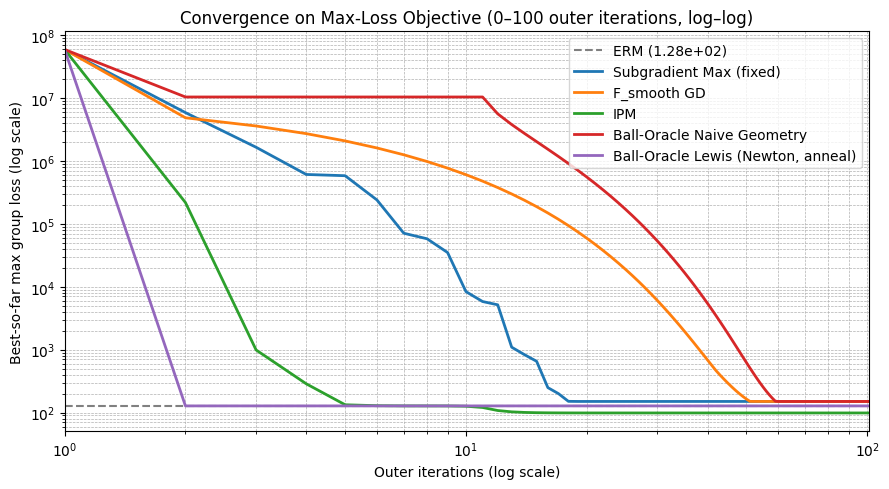

In [ ]:
# ============================================================
# Block: Final Convergence Plot (0–100 outer its, log–log)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Helper: pick best label from a list of candidate labels by results_final
def pick_best_label(candidates, results_final):
    best_label = None
    best_val = float("inf")
    for lbl in candidates:
        if lbl in results_final:
            val = results_final[lbl]
            if np.isfinite(val) and val < best_val:
                best_val = val
                best_label = lbl
    return best_label

# Define families
subgrad_family = [
    "Subgradient Max (fixed)",
    "Subgradient Max (dim)",
    "Subgradient Max",
]
smooth_family = [
    "F_smooth GD",
]
ipm_family = [
    "IPM",
]
naive_family = [
    "Ball-Oracle Naive Geometry",
    "Ball-Oracle Naive Geometry (anneal)",
]
lewis_family = [
    "Ball-Oracle Lewis Geometry",
    "Ball-Oracle Lewis Geometry (anneal)",
    "Ball-Oracle Lewis (Newton, outer iters)",
    "Ball-Oracle Lewis (Newton, anneal)",
]

selected_labels = []

# Pick best-of for each family, if available
best_subgrad = pick_best_label(subgrad_family, results_final)
if best_subgrad is not None:
    selected_labels.append(best_subgrad)

best_smooth = pick_best_label(smooth_family, results_final)
if best_smooth is not None:
    selected_labels.append(best_smooth)

best_ipm = pick_best_label(ipm_family, results_final)
if best_ipm is not None:
    selected_labels.append(best_ipm)

# Our naive geometry (one curve)
best_naive = pick_best_label(naive_family, results_final)
if best_naive is not None:
    selected_labels.append(best_naive)

# Our Lewis geometry (one curve)
best_lewis = pick_best_label(lewis_family, results_final)
if best_lewis is not None:
    selected_labels.append(best_lewis)

plt.figure(figsize=(9, 5))

# ERM baseline (horizontal line)
erm_val = None
if "ERM" in results_final and np.isfinite(results_final["ERM"]):
    erm_val = results_final["ERM"]
elif "ERM baseline" in results_final and np.isfinite(results_final["ERM baseline"]):
    erm_val = results_final["ERM baseline"]

if erm_val is not None:
    plt.axhline(
        y=erm_val,
        linestyle="--",
        linewidth=1.5,
        color="gray",
        label=f"ERM ({erm_val:.2e})",
    )

# Plot selected curves
for label in selected_labels:
    data = results_curves.get(label, None)
    if data is None:
        continue

    iters = np.asarray(data.get("iters", []), dtype=float)
    vals = np.asarray(data.get("best_values", []), dtype=float)
    if iters.size == 0 or vals.size == 0:
        continue

    # Keep finite points
    mask = np.isfinite(iters) & np.isfinite(vals)
    iters = iters[mask]
    vals = vals[mask]
    if iters.size == 0:
        continue

    # Shift by +1 so that iteration 0 maps to x=1 (valid for log scale)
    x_plot = iters + 1.0

    # Slight markers only if few points (e.g., IPM)
    marker = "o" if len(x_plot) <= 40 else None

    plt.plot(
        x_plot,
        vals,
        label=label,
        linewidth=2.0,
        marker=marker,
        markersize=4 if marker else 0,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlim(left=1.0, right=101.0)  # 0..100 outer iterations -> 1..101 on x-axis
plt.xlabel("Outer iterations (log scale)")
plt.ylabel("Best-so-far max group loss (log scale)")
plt.title("Convergence on Max-Loss Objective (0–100 outer iterations, log–log)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

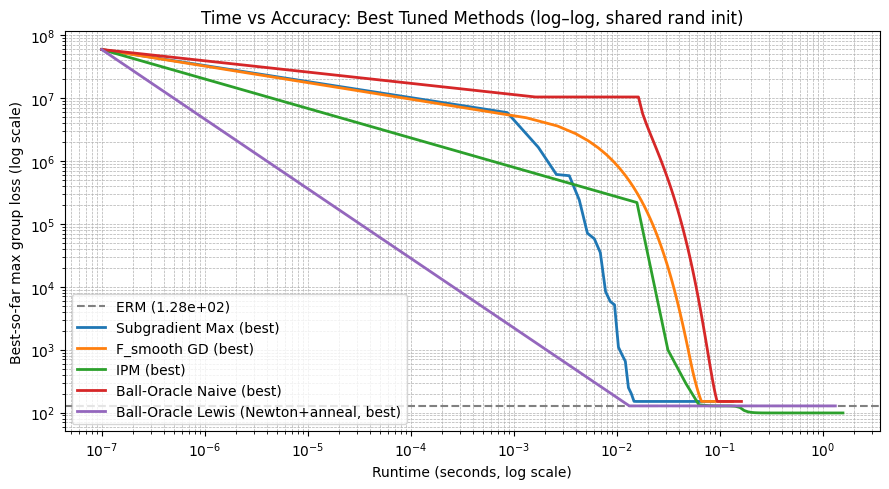

In [ ]:
# ============================================================
# Block: Time vs Accuracy for Best Tuned Methods (log–log)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# Shared random init so timing comparison is fair
x0_time = get_init("rand")

# ------------------ Helpers ------------------ #

def monotone_best(vals):
    vals = np.asarray(vals, float).copy()
    for i in range(1, len(vals)):
        if vals[i] > vals[i - 1]:
            vals[i] = vals[i - 1]
    return vals

def scaled_times(iters, total_runtime):
    iters = np.asarray(iters, float)
    if iters.size == 0:
        return np.array([])
    T_max = max(float(iters[-1]), 1.0)
    total = max(float(total_runtime), 1e-9)
    return (iters / T_max) * total

# ---- Subgradient ----

def timed_run_subgrad(A_groups, b_groups, x0, cfg, T=100):
    if cfg is None:
        print("[Time plot] No subgrad_cfg; skipping.")
        return None
    mode = cfg.get("mode", "fixed")

    start = time.perf_counter()
    if mode == "fixed":
        res = run_subgradient_max_fixed(
            A_groups, b_groups, x0,
            step=cfg["step"],
            T=T,
            verbose=False,
            record_curve=True,
        )
    else:
        res = run_subgradient_max_diminishing(
            A_groups, b_groups, x0,
            base_step=cfg["base_step"],
            T=T,
            verbose=False,
            record_curve=True,
        )
    end = time.perf_counter()

    if res is None or res.get("iters") is None or res.get("best_values") is None:
        print("[Time plot] Subgrad run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return times, vals

# ---- Smoothed GD ----

def timed_run_smooth(A_groups, b_groups, x0, cfg, T=100):
    if cfg is None:
        print("[Time plot] No smooth_cfg; skipping.")
        return None

    start = time.perf_counter()
    res = run_smooth_gd(
        A_groups, b_groups, x0,
        beta=cfg["beta"],
        delta=cfg["delta"],
        step=cfg["step"],
        T=T,
        verbose=False,
        record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None or res.get("best_values") is None:
        print("[Time plot] F_smooth GD run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return times, vals

# ---- IPM ----

def timed_run_ipm(A_groups, b_groups, x0, cfg, max_steps=100):
    if cfg is None:
        print("[Time plot] No ipm_cfg; skipping.")
        return None

    start = time.perf_counter()
    res = run_ipm(
        A_groups, b_groups, x0,
        mu0=cfg["mu0"],
        tau=cfg["tau"],
        inner_iters=cfg["inner_iters"],
        max_newton_steps=max_steps,
        verbose=False,
        record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None or res.get("best_values") is None:
        print("[Time plot] IPM run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return times, vals

# ---- Ball-Oracle Naive ----

def timed_run_naive(A_groups, b_groups, x0, cfg, max_iters=100):
    if cfg is None:
        print("[Time plot] No naive_cfg; skipping.")
        return None

    start = time.perf_counter()
    res = run_ball_oracle_naive(
        A_groups, b_groups, x0,
        beta=cfg["beta"],
        delta=cfg["delta"],
        step=cfg["step"],
        R0=cfg["R0"],
        n_outer=cfg["n_outer"],
        n_inner=cfg["n_inner"],
        shrink=cfg["shrink"],
        max_iters=max_iters,
        verbose=False,
        record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None or res.get("best_values") is None:
        print("[Time plot] Ball-Oracle Naive run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return times, vals

# ---- Ball-Oracle Lewis Newton / Newton+Anneal ----

def timed_run_lewis_newton_best(A_groups, b_groups, x0, cfg, n_outer=100):
    """
    Run the best Lewis-geometry Newton-style method.

    Compatible with:
      - lewis_newton_anneal_cfg: {beta0, beta_decay, R0, R_decay}
      - lewis_newton_cfg:       {beta, R0, R_decay?} (treated as beta0, no anneal)

    Uses whichever of:
      - run_ball_oracle_lewis_newton_anneal
      - run_ball_oracle_lewis_newton
    is defined in the environment.

    Expects the run_* function to return either:
      - 'iters' & 'best_values', or
      - 'outer_iters' & 'outer_best_values'.
    """
    if cfg is None:
        print("[Time plot] No Lewis Newton cfg; skipping.")
        return None

    # Pick implementation
    if "run_ball_oracle_lewis_newton_anneal" in globals():
        run_fn = globals()["run_ball_oracle_lewis_newton_anneal"]
        use_anneal_style = True
    elif "run_ball_oracle_lewis_newton" in globals():
        run_fn = globals()["run_ball_oracle_lewis_newton"]
        use_anneal_style = False
    else:
        print("[Time plot] No Lewis Newton run function found.")
        return None

    # Extract parameters in a robust way
    if use_anneal_style:
        beta0 = float(cfg.get("beta0", cfg.get("beta", 1.0)))
        beta_decay = float(cfg.get("beta_decay", 1.0))
        R0 = float(cfg.get("R0", 1.0))
        R_decay = float(cfg.get("R_decay", 1.0))
        start = time.perf_counter()
        res = run_fn(
            A_groups,
            b_groups,
            x0,
            beta0=beta0,
            beta_decay=beta_decay,
            R0=R0,
            R_decay=R_decay,
            n_outer=n_outer,
            verbose=False,
            record_curve=True,
        )
        end = time.perf_counter()
    else:
        # Non-annealed Newton: treat cfg["beta"] as fixed beta0, decay=1
        beta0 = float(cfg.get("beta", 1.0))
        R0 = float(cfg.get("R0", 1.0))
        R_decay = float(cfg.get("R_decay", 1.0))
        start = time.perf_counter()
        res = run_fn(
            A_groups,
            b_groups,
            x0,
            beta0=beta0,
            beta_decay=1.0,
            R0=R0,
            R_decay=R_decay,
            n_outer=n_outer,
            verbose=False,
            record_curve=True,
        )
        end = time.perf_counter()

    if res is None:
        print("[Time plot] Lewis Newton run failed: res is None.")
        return None

    # Try multiple key conventions
    iters = res.get("iters")
    vals = res.get("best_values")

    if iters is None or vals is None:
        iters = res.get("outer_iters", iters)
        vals = res.get("outer_best_values", vals)

    if iters is None or vals is None:
        print("[Time plot] Lewis Newton run missing iters/best_values. Keys:", list(res.keys()))
        return None

    iters = np.asarray(iters, float)
    vals = monotone_best(vals)
    times = scaled_times(iters, end - start)
    return times, vals

# ------------------ Collect curves ------------------ #

time_curves = {}

if "subgrad_cfg" in globals():
    out = timed_run_subgrad(A_groups, b_groups, x0_time, subgrad_cfg, T=100)
    if out is not None:
        time_curves["Subgradient Max (best)"] = out

if "smooth_cfg" in globals():
    out = timed_run_smooth(A_groups, b_groups, x0_time, smooth_cfg, T=100)
    if out is not None:
        time_curves["F_smooth GD (best)"] = out

if "ipm_cfg" in globals():
    out = timed_run_ipm(A_groups, b_groups, x0_time, ipm_cfg, max_steps=100)
    if out is not None:
        time_curves["IPM (best)"] = out

if "naive_cfg" in globals():
    out = timed_run_naive(A_groups, b_groups, x0_time, naive_cfg, max_iters=100)
    if out is not None:
        time_curves["Ball-Oracle Naive (best)"] = out

# Lewis: prefer annealed Newton if available, else plain Newton
lewis_cfg = None
lewis_label = None

if "lewis_newton_anneal_cfg" in globals():
    lewis_cfg = lewis_newton_anneal_cfg
    lewis_label = "Ball-Oracle Lewis (Newton+anneal, best)"
elif "lewis_newton_cfg" in globals():
    lewis_cfg = lewis_newton_cfg
    lewis_label = "Ball-Oracle Lewis (Newton, best)"

if lewis_cfg is not None:
    out = timed_run_lewis_newton_best(A_groups, b_groups, x0_time, lewis_cfg, n_outer=100)
    if out is not None:
        time_curves[lewis_label] = out
    else:
        print("[Time plot] Lewis Newton timing run returned None.")
else:
    print("[Time plot] No Lewis Newton cfg found; skipping Lewis curve.")

# ------------------ Plot (log–log) ------------------ #

plt.figure(figsize=(9, 5))

# ERM baseline
erm_val = None
if "ERM" in results_final and np.isfinite(results_final["ERM"]):
    erm_val = results_final["ERM"]
elif "ERM baseline" in results_final and np.isfinite(results_final["ERM baseline"]):
    erm_val = results_final["ERM baseline"]

if erm_val is not None:
    plt.axhline(
        y=erm_val,
        linestyle="--",
        linewidth=1.5,
        color="gray",
        label=f"ERM ({erm_val:.2e})",
    )

for label, (times, vals) in time_curves.items():
    times = np.asarray(times, float)
    vals = np.asarray(vals, float)

    mask = np.isfinite(times) & np.isfinite(vals)
    times, vals = times[mask], vals[mask]
    if times.size == 0:
        continue

    # Avoid log(0)
    times = np.maximum(times, 1e-7)

    marker = "o" if len(times) <= 40 else None
    plt.plot(
        times,
        vals,
        label=label,
        linewidth=2.0,
        marker=marker,
        markersize=4 if marker else 0,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Runtime (seconds, log scale)")
plt.ylabel("Best-so-far max group loss (log scale)")
plt.title("Time vs Accuracy: Best Tuned Methods (log–log, shared rand init)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()